## Mean Reversion strategy using sinewave smooth filter 

Filter is applied to close price on a 10 day horizon
This indicator measures market cycles and uses a low pass filter to remove noise.

Its output is bound signal between -1 and 1 and the maximum length of a detected
trend is limited by its length input (here 10 days length input).


In [8]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2010-05-07,UAA,2010-05-07,32.5444,33.2468,30.5708,31.1908,3.8989,5991816,1.319225e+10
2011-09-28,BRO,2011-09-28,18.5700,18.5700,17.8900,17.9000,7.8680,1661982,5.172256e+09
2017-05-19,POOL,2017-05-19,118.4400,119.5800,117.3300,119.1700,112.4526,123522,5.056913e+09
2014-11-11,ITW,2014-11-11,93.0700,93.5000,92.7100,93.0000,76.2874,1789402,3.693018e+10
2013-04-11,BA,2013-04-11,87.9600,89.4600,87.8400,88.5300,74.6637,5394200,6.747211e+10


In [10]:
def better_sinewave(close, length=None, bars=None, offset=None, **kwargs):

    # Validate arguments
    length = int(length) if length and length > 38 else 40
    bars = int(bars) if bars and bars > 0 else 10
    offset = int(offset) if offset else 0

    if close is None: return

    # variables
    alpha1 = HP = 0 # alpha and HighPass
    a1 = b1 = c1 = c2 = c3 = 0
    Filt = Pwr = Wave = 0

    lastClose = lastHP = 0
    FilterHist = [0, 0]   # Filter history

    # Calculate Result
    m = close.size
    result = [np.nan for _ in range(0, length - 1)] + [0]
    for i in range(length, m):
        # HighPass filter cyclic components whose periods are shorter than Duration input
        alpha1 = (1 - np.sin(360 / length)) / np.cos(360 / length)
        HP = 0.5 * (1 + alpha1) * (close[i] - lastClose) + alpha1 * lastHP

        # Smooth with a Super Smoother Filter from equation 3-3
        a1 = np.exp(-np.sqrt(2) * np.pi / bars)
        b1 = 2 * a1 * np.cos(np.sqrt(2) * 180 / bars)
        c2 = b1
        c3 = -1 * a1 * a1
        c1 = 1 - c2 - c3
        Filt = c1 * (HP + lastHP) / 2 + c2 * FilterHist[1] + c3 * FilterHist[0]
        # Filt = float("{:.8f}".format(float(Filt))) # to fix for small scientific notations, the big ones fail

        # 3 Bar average of Wave amplitude and power
        Wave = (Filt + FilterHist[1] + FilterHist[0]) / 3
        Pwr = (Filt * Filt + FilterHist[1] * FilterHist[1] + FilterHist[0] * FilterHist[0]) / 3

        # Normalize the Average Wave to Square Root of the Average Power
        Wave = Wave / np.sqrt(Pwr)

        # update storage, result
        FilterHist.append(Filt)  # append new Filt value
        FilterHist.pop(0)  # remove first element of list (left) -> updating/trim
        lastHP = HP
        lastClose = close[i]
        result.append(Wave)

    ebsw = pd.Series(result, index=close.index)

    # Offset
    if offset != 0:
        ebsw = ebsw.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        ebsw.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        ebsw.fillna(method=kwargs["fill_method"], inplace=True)

    return ebsw

In [11]:
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    df_ticker = market_data.xs(ticker,level=1)
    try :
        metrics = better_sinewave(df_ticker['close'],bars = 5,length=10)
        results[ticker] = metrics
    except :
        print(ticker, 'not computed')
results = pd.concat(results,axis=1)
results = results.reindex_like(P).ffill()

 12%|█▏        | 107/866 [00:08<00:50, 14.95it/s]

BHGE not computed


 44%|████▍     | 379/866 [00:28<00:31, 15.46it/s]

HET not computed


100%|██████████| 866/866 [01:08<00:00, 12.66it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_21476\1994935659.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center) ## hedge by sector gics


Sharpe      1.4
Turnover    0.8
biais       2.7
dtype: float64

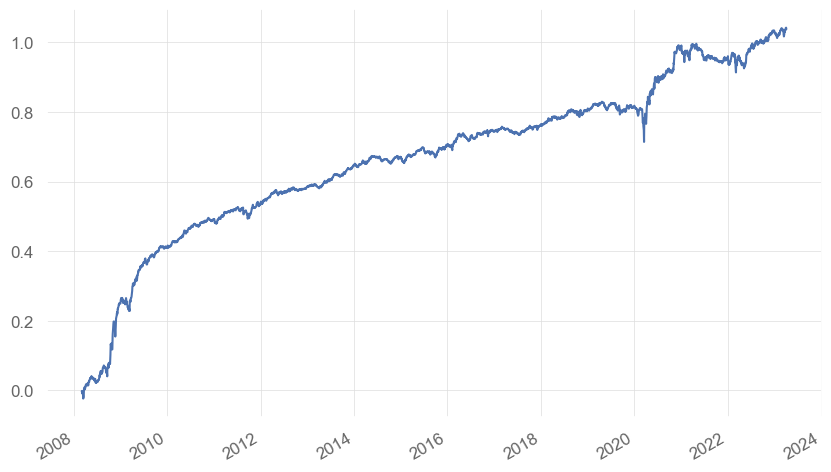

In [5]:
signal = results[P].ffill()
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf) ## cross sectionnal rank
signal[signal.abs()<0.5] = None ## not playing the middle of the distribution

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center) ## hedge by sector gics
signal = signal[P].div(signal[P].abs().sum(1),0) ## constant GMV = 1

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(1)

Text(0, 0.5, '# stocks held in portfolio')

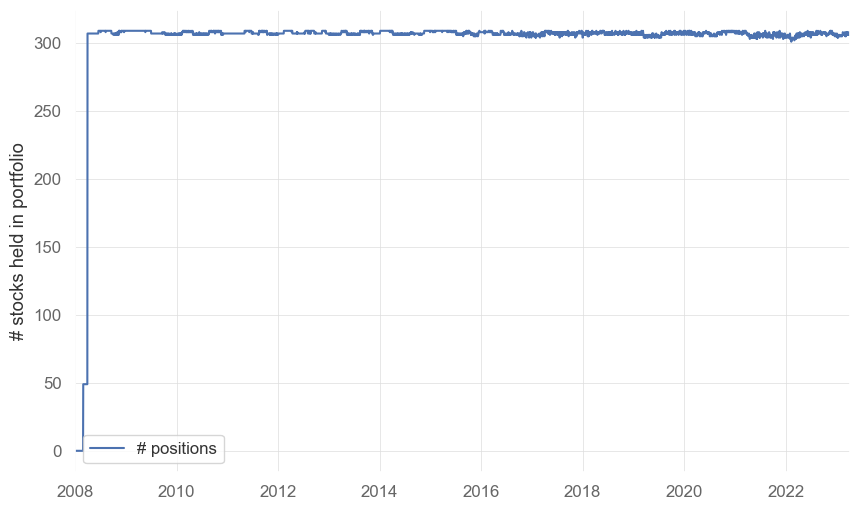

In [6]:
signal.count(1).plot(label ='# positions',legend=True)
plt.ylabel('# stocks held in portfolio')

<Axes: >

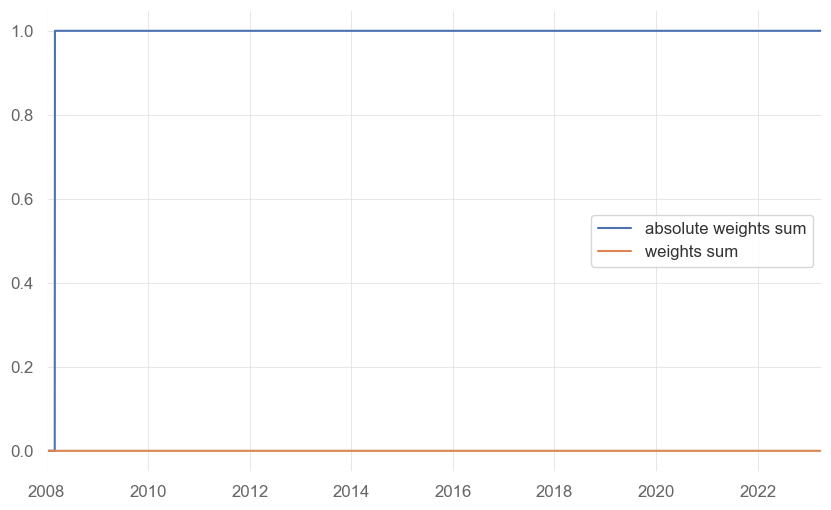

In [7]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)